## 1. Datenvorbereitung inklusive Objektvariablen
a) Identifikation und Bereinigung der Daten

Bereinigung: Fehlende Werte und Ausreißer erkennen und behandeln.
Trennung der Variablentypen: Ermittele, welche Variablen numerisch und welche als Objekt (kategorial) vorliegen.

b) Re-Codierung der Objektvariablen

Recodierung: Wandle die kategorialen Variablen in numerische Werte um (z. B. mittels LabelEncoder oder alternativ One-Hot-Encoding, falls dies sinnvoll ist).
Speichern der Originallabels: Bewahre die Mapping-Dictionarys bzw. die Originallabels separat auf, damit Du später in Grafiken die aussagekräftigen Labels anzeigen kannst.

In [5]:
import os
import pandas as pd
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn import preprocessing, model_selection
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, silhouette_samples
import numpy as np
import matplotlib.cm as cm
import seaborn as sns
import matplotlib.pyplot as plt 

# Setze den relativen Pfad zur Datei
dateipfad = os.path.join("/Users/danielambach/Projects/data_mining_dsba/data/processed/", "hotel_bookings_processed.csv")

df = pd.read_csv(dateipfad)

# Filtere den DataFrame auf Zeilen, bei denen die Buchungen nicht storniert wurden also is_canceled == 0 hat:
df = df[df['is_canceled'] == 0]

# Trenne numerische und kategoriale (object) Variablen
numeric_features = df.select_dtypes(include=['float64', 'int64']).columns.tolist()
object_features = df.select_dtypes(include=['object']).columns.tolist()

# Erstelle Kopien der Originalobjektvariablen für spätere Visualisierungen
df_original_labels = df[object_features].copy()

# Label-Encoding der Objektvariablen und Speicherung der Mapping-Dictionaries
encoders = {}
for col in object_features:
    le = LabelEncoder()
    df[col + '_encoded'] = le.fit_transform(df[col])
    # Speichere Mapping: Originalkategorie -> kodierter Wert
    encoders[col] = dict(zip(le.classes_, le.transform(le.classes_)))

# Wähle die Features für die Clusteranalyse: numerische Features und recodierte Objektvariablen
features_for_clustering = numeric_features + [col + '_encoded' for col in object_features]
X = df[features_for_clustering]

# Skalierung der Daten (wichtig, da K-Means euklidische Distanzen verwendet)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


## 2. Bestimmung der optimalen Clusterzahl: Elbow-Methode

Hier führst Du K-Means für verschiedene Clusterzahlen (z. B. 1 bis 10) aus und zeichnest die Summe der quadratischen Abweichungen (SSE bzw. Inertia) auf. Der Punkt, an dem sich der Abfall verlangsamt („Elbow“), liefert einen guten Hinweis auf die optimale Anzahl von Clustern.

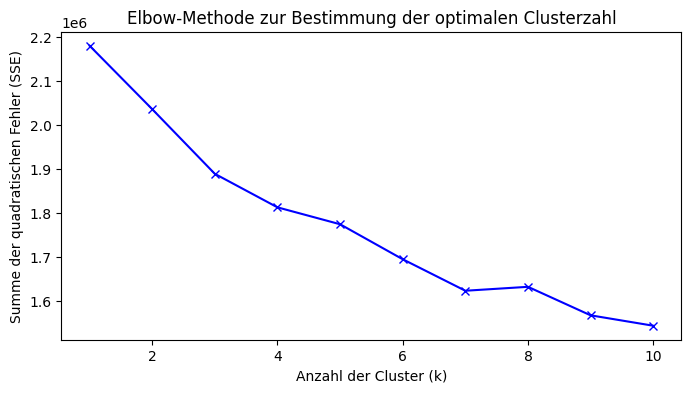

In [6]:
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(8, 4))
plt.plot(k_range, sse, 'bx-')
plt.xlabel("Anzahl der Cluster (k)")
plt.ylabel("Summe der quadratischen Fehler (SSE)")
plt.title("Elbow-Methode zur Bestimmung der optimalen Clusterzahl")
plt.show()


### Interpretation:

Elbow-Punkt: Beobachte den Plot. Der erste Knick ist bei k = 3 erkennbar, spricht das für die Wahl dieser Anzahl an Clustern.
Overfitting vermeiden: Mehr Cluster als nötig können zu Overfitting und schwer interpretierbaren Ergebnissen führen.

## 3. Durchführung der Clusteranalyse und Silhouettenbewertung
a) Clustering mit K-Means

Wähle die optimale Clusterzahl (k = 3) und führe das Clustering durch.

In [10]:
# Wähle die optimale Clusterzahl (als Beispiel k = 2)
optimal_k = 2
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_scaled)

# Füge die Clusterlabels dem DataFrame hinzu
df['Cluster'] = cluster_labels


b) Silhouettenanalyse zur Bewertung der Clusterqualität

Berechne den durchschnittlichen Silhouettenwert sowie die Silhouettenwerte für einzelne Datenpunkte und visualisiere diese.

Durchschnittlicher Silhouettenwert für k = 2: 0.097


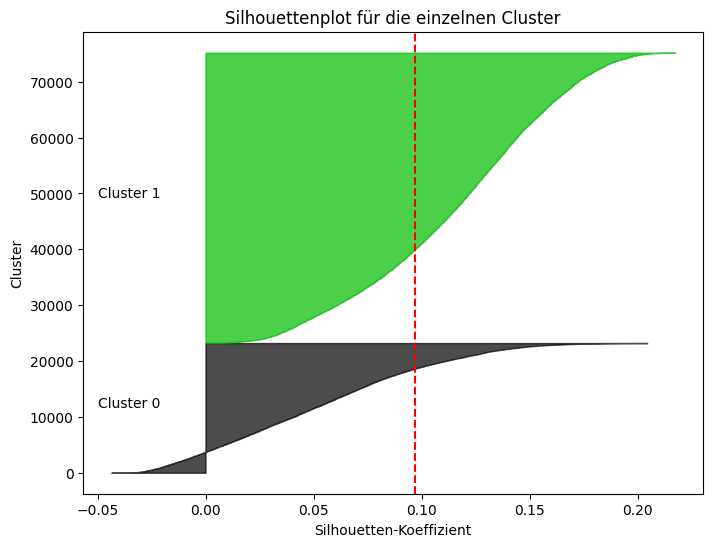

In [38]:
# Durchschnittlicher Silhouettenwert
silhouette_avg = silhouette_score(X_scaled, cluster_labels)
print(f"Durchschnittlicher Silhouettenwert für k = {optimal_k}: {silhouette_avg:.3f}")

# Silhouettenwerte für jeden Datenpunkt
sample_silhouette_values = silhouette_samples(X_scaled, cluster_labels)

# Erstelle den Silhouettenplot
plt.figure(figsize=(8, 6))
y_lower = 10
for i in range(optimal_k):
    ith_cluster_values = sample_silhouette_values[cluster_labels == i]
    ith_cluster_values.sort()
    size_cluster_i = ith_cluster_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = cm.nipy_spectral(float(i) / optimal_k)
    plt.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_values,
                      facecolor=color, edgecolor=color, alpha=0.7)
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, f"Cluster {i}")
    y_lower = y_upper + 10  # Abstand zwischen den Clustern

plt.axvline(x=silhouette_avg, color="red", linestyle="--")
plt.xlabel("Silhouetten-Koeffizient")
plt.ylabel("Cluster")
plt.title("Silhouettenplot für die einzelnen Cluster")
plt.show()


### Interpretation:

Hoher Durchschnittswert (nahe 1): Deutet darauf hin, dass die Datenpunkte gut zu ihren Clustern passen.
Werte nahe 0: Punkte liegen an der Grenze zwischen Clustern.
Negative Werte: Mögliche Fehlzuordnungen, da der Punkt näher an einem anderen Cluster liegen könnte.

## 4. Visualisierung unter Einbeziehung der ursprünglichen Objektlabels

Nachdem die Clusteranalyse durchgeführt wurde, kannst Du die Ergebnisse visualisieren – beispielsweise durch Streudiagramme, Boxplots oder Balkendiagramme. Dabei kommen die zuvor gespeicherten Originallabels zum Einsatz, um die Interpretation der Cluster zu erleichtern.

Beispiel: Visualisierung eines kategorialen Merkmals (z. B. "Kategorie") innerhalb der Cluster

In [8]:
print(df.columns)

Index(['hotel', 'is_canceled', 'lead_time', 'arrival_date_year',
       'arrival_date_month', 'arrival_date_week_number',
       'arrival_date_day_of_month', 'stays_in_weekend_nights',
       'stays_in_week_nights', 'adults', 'children', 'babies', 'meal',
       'country', 'market_segment', 'distribution_channel',
       'is_repeated_guest', 'previous_cancellations',
       'previous_bookings_not_canceled', 'reserved_room_type',
       'assigned_room_type', 'booking_changes', 'deposit_type',
       'days_in_waiting_list', 'customer_type', 'adr',
       'required_car_parking_spaces', 'total_of_special_requests',
       'reservation_status', 'reservation_status_date', 'company_agent',
       'hotel_encoded', 'arrival_date_month_encoded', 'meal_encoded',
       'country_encoded', 'market_segment_encoded',
       'distribution_channel_encoded', 'reserved_room_type_encoded',
       'assigned_room_type_encoded', 'deposit_type_encoded',
       'customer_type_encoded', 'reservation_status_enco

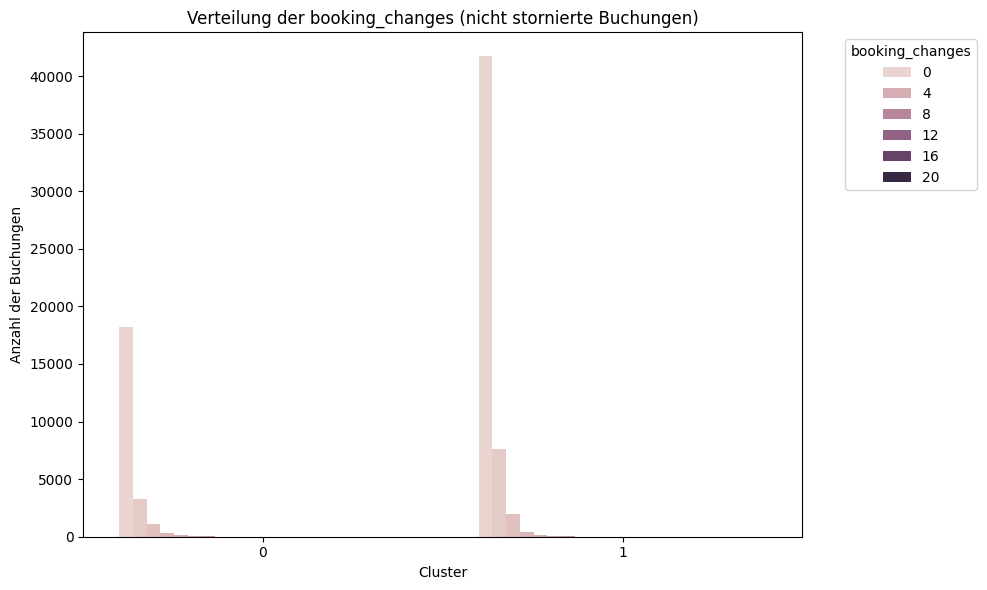

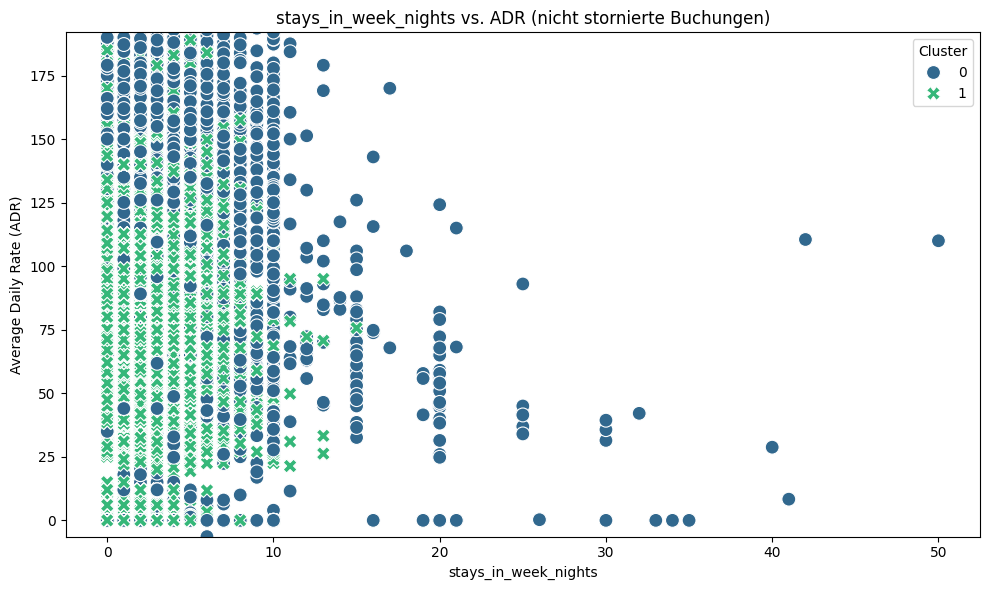

In [11]:

# 3a. Visualisierung: Countplot der booking_changes pro Cluster
plt.figure(figsize=(10, 6))
sns.countplot(data=df, x='Cluster', hue='booking_changes')
plt.title('Verteilung der booking_changes (nicht stornierte Buchungen)')
plt.xlabel('Cluster')
plt.ylabel('Anzahl der Buchungen')
plt.legend(title='booking_changes', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# 3b. Visualisierung: Scatter Plot von vs. ADR (Average Daily Rate) nach Cluster
# Bestimme den unteren und oberen Grenzwert für ADR:
lower_limit = df['adr'].min()
upper_limit = df['adr'].quantile(0.95)  # oberes Limit auf 95. Perzentil setzen


# Erstelle den Scatter-Plot und setze die y-Achse (ADR) auf den definierten Bereich
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='stays_in_week_nights', y='adr', hue='Cluster', palette='viridis', style='Cluster', s=100)
plt.title('stays_in_week_nights vs. ADR (nicht stornierte Buchungen)')
plt.xlabel('stays_in_week_nights')
plt.ylabel('Average Daily Rate (ADR)')
plt.ylim(lower_limit, upper_limit)  # y-Achse auf definierten Bereich beschränken
plt.legend(title='Cluster')
plt.tight_layout()
plt.show()

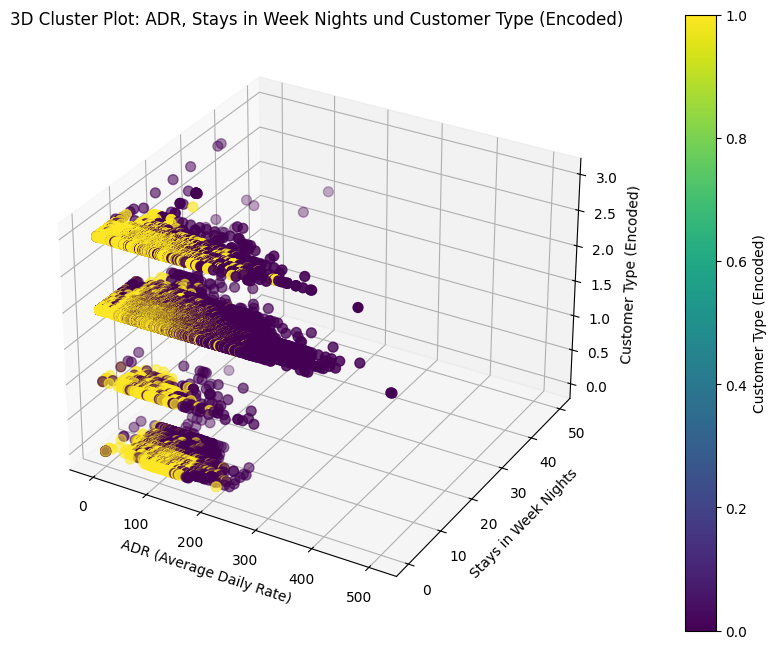

In [14]:
# Erstelle den 3D Scatter-Plot
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Punkte plotten: Die Farbe der Punkte orientiert sich am encoded customer type
scatter = ax.scatter(
    df['adr'],
    df['stays_in_week_nights'],
    df['customer_type_encoded'],
    c=df['Cluster'], cmap='viridis', s=50
)

# Achsenbeschriftung setzen
ax.set_xlabel('ADR (Average Daily Rate)')
ax.set_ylabel('Stays in Week Nights')
ax.set_zlabel('Customer Type (Encoded)')

# Titel und Farbleiste hinzufügen
plt.title('3D Cluster Plot: ADR, Stays in Week Nights und Customer Type (Encoded)')
cbar = plt.colorbar(scatter, pad=0.1)
cbar.set_label('Customer Type (Encoded)')

plt.show()